In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier
import shap

> 클러스터

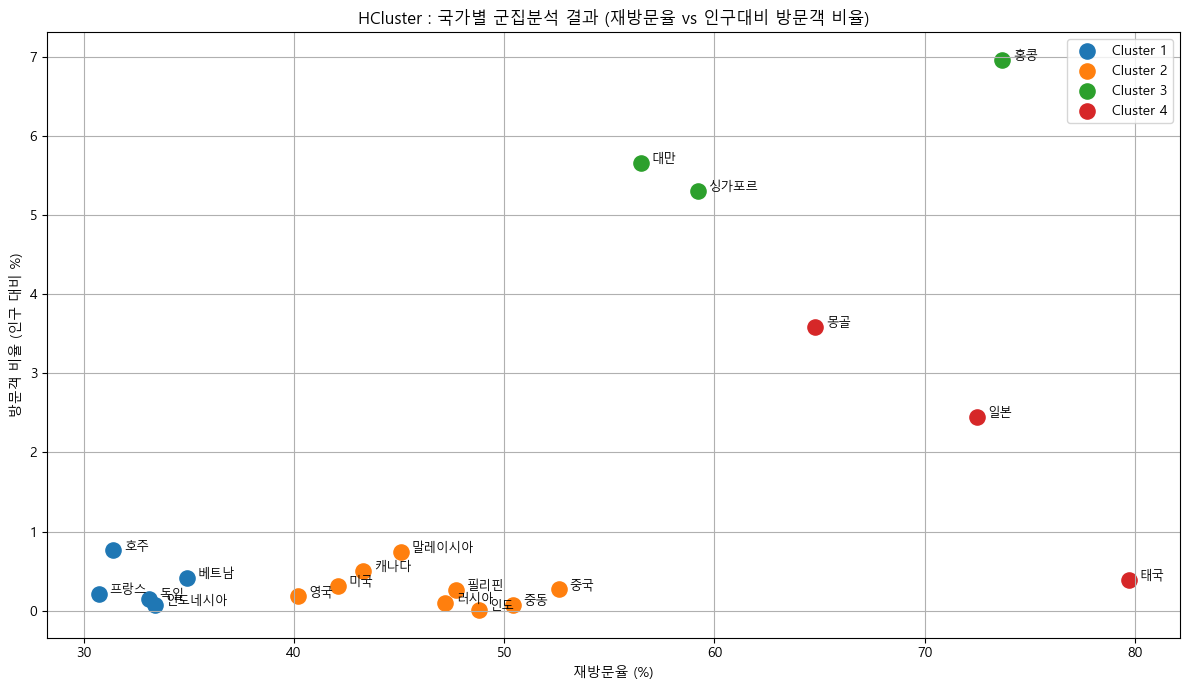

> 클러스터별 추천 종속변수

| 클러스터               | 포함 국가                         | 특성 요약                 | 추천 종속변수                               | 변수명                                                     |
| ------------------ | ----------------------------- | --------------------- | ------------------------------------- | ------------------------------------------------------- |
| **Cluster 1 (파랑)** | 호주, 프랑스, 독일, 베트남, 인도네시아       | 방문 비율/재방문율 낮음 → 신규시장  | **재방문 가능성**, **만족도**                  | `재방문여부`, `재방문의사`, `만족도`                                 |
| **Cluster 2 (주황)** | 미국, 중국, 필리핀, 말레이시아, 캐나다, 인도 등 | 방문도 재방문도 중간 → 안정시장    | **총 소비**, **1일 지출**, **추천의향**         | `1인 총소비_국제교통비 포함`, `1인 체류일별 소비금액`, `재방문의사`              |
| **Cluster 3 (초록)** | 홍콩, 대만, 싱가포르                  | 방문율·재방문율 모두 높음 → VIP층 | **1일 지출**, **항목별 소비성향**               | `1인 체류일별 소비금액`, `쇼핑장소_면세점`, `만족활동_쇼핑`, `만족활동_한류`        |
| **Cluster 4 (빨강)** | 일본, 태국, 몽골                    | 재방문율 매우 높음 → 소비 확대 대상 | **1인 총 소비**, **소비 항목별 지출**, **활동 참여** | `1인 총소비_국제교통비 포함`, `만족활동_미식`, `만족활동_전통문화`, `만족활동_오락/유흥` |


> 종속변수가 재방문 여부일 때, 설명변수 제외할 것

In [5]:
df = pd.read_csv('../data/최종모델링데이터_Final.csv')

In [6]:
# 경험 선택자 중 재방문자 비율
n_experience = df[df["Q1_관심계기_경험"] == True].shape[0]
n_experience_and_revisit = df[(df["Q1_관심계기_경험"] == True) & (df["재방문여부"] == True)].shape[0]
p_revisit_given_experience = n_experience_and_revisit / n_experience

# 새로움 선택자 중 비재방문자 비율
n_newness = df[df["Q1_관심계기_새로움"] == True].shape[0]
n_newness_and_nonrevisit = df[(df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == False)].shape[0]
p_nonrevisit_given_newness = n_newness_and_nonrevisit / n_newness

print(f"P(재방문자 | '경험') = {p_revisit_given_experience:.3%}")
print(f"P(비재방문자 | '새로움') = {p_nonrevisit_given_newness:.3%}")


P(재방문자 | '경험') = 100.000%
P(비재방문자 | '새로움') = 99.964%


In [7]:
# 새로움을 선택했지만 재방문자인 사람
mask = (df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == True)
df_exception = df[mask]

print(f"예외 행 수: {df_exception.shape[0]}")
df_exception

예외 행 수: 1


,재방문여부,여행형태_개별여행,여행형태_에어텔,여행형태_단체여행,Q1_응답대상,Q1_관심계기_경제성,Q1_관심계기_경험,Q1_관심계기_기타,Q1_관심계기_문화콘텐츠,Q1_관심계기_새로움,...,월_7,월_8,월_9,월_10,월_11,월_12,분기_1,분기_2,분기_3,분기_4
13076,1,True,False,False,1,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True


# Cluster 2

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [8]:
# 클러스터 국가 리스트
cluster2_countries = [
    '국가_미국', '국가_중국', '국가_필리핀', '국가_말레이시아',
    '국가_인도', '국가_중동', '국가_캐나다', '국가_러시아', '국가_영국'
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster2_mask = df[cluster2_countries].any(axis=1)
df_c2 = df[cluster2_mask].copy()

In [9]:
# 종속변수
y = df_c2["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

In [10]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [12]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.474]
Accuracy     : 0.696
Precision    : 0.699
Recall       : 0.698
F1 Score     : 0.698
ROC AUC      : 0.754

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.694     0.695     0.694 890054.329999999
           1      0.699     0.698     0.698 904245.7800000005

    accuracy                          0.696 1794300.1099999994
   macro avg      0.696     0.696     0.696 1794300.1099999994
weighted avg      0.696     0.696     0.696 1794300.1099999994


▶ [혼동 행렬]
[[773 338]
 [302 689]]


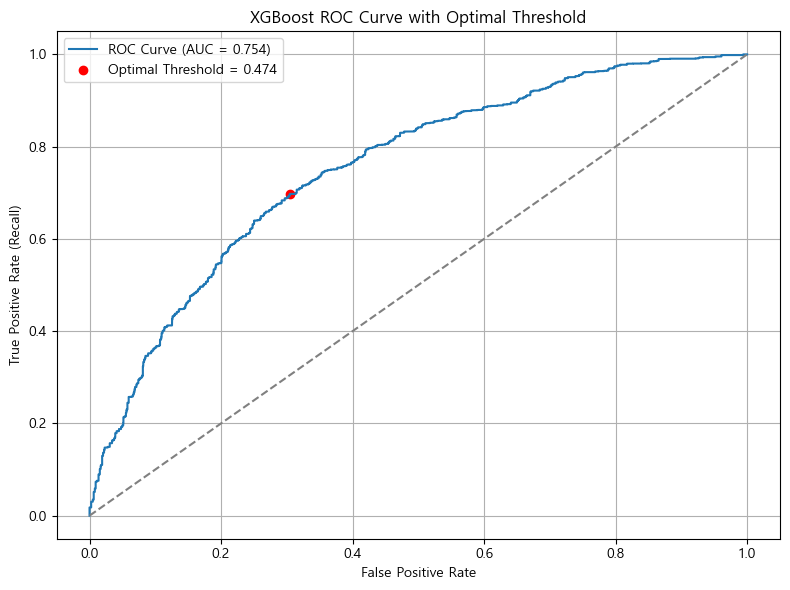

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

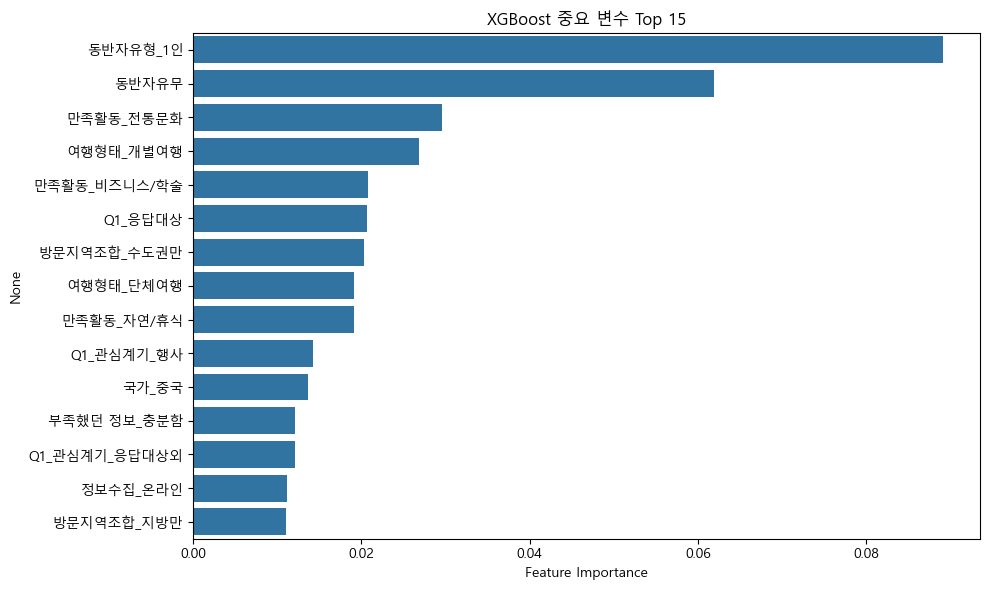

In [14]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

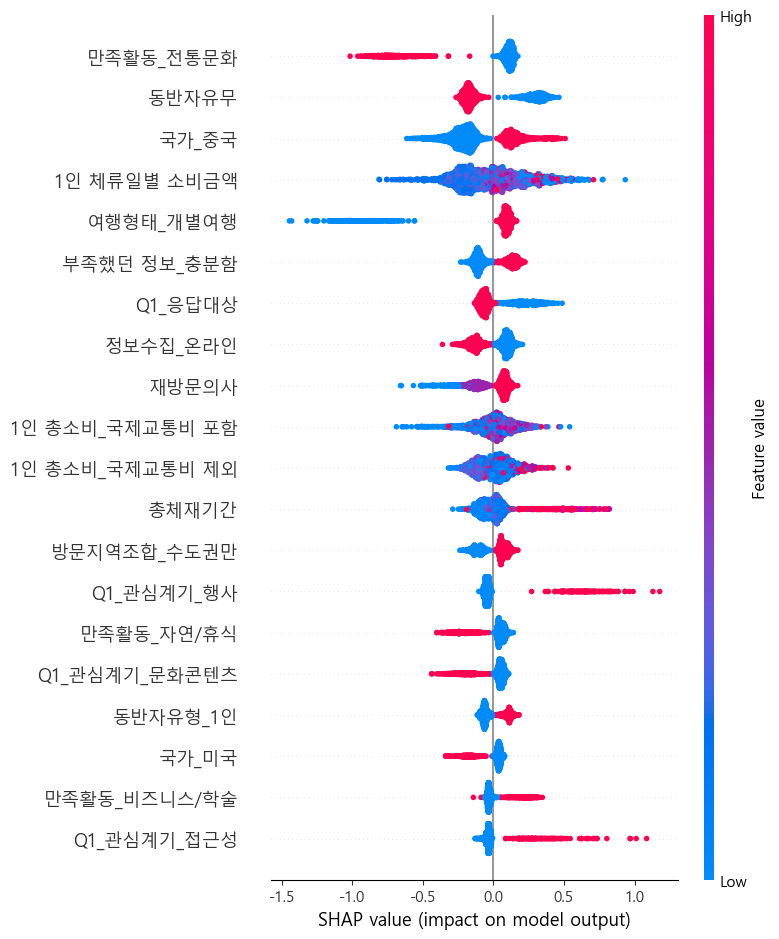

In [15]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [16]:
import pandas as pd
import numpy as np
import shap

# 2. SHAP 값을 numpy 배열로 추출
shap_array = shap_values.values  # (n_samples, n_features)
shap_df = pd.DataFrame(shap_array, columns=X_test.columns)

# 3. 통계 요약
summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_array).mean(axis=0),
    'mean_shap': shap_array.mean(axis=0),
    'std_shap': shap_array.std(axis=0),
    'positive_ratio': (shap_array > 0).mean(axis=0)
})

# 4. 방향성 분류
summary['directionality'] = np.where(summary['positive_ratio'] > 0.9, 'strong_positive',
                            np.where(summary['positive_ratio'] < 0.1, 'strong_negative', 'neutral'))

# 5. 영향력 상위 변수 필터링
threshold = summary['mean_abs_shap'].quantile(0.8)
top_influential = summary[summary['mean_abs_shap'] > threshold]

# 6. 이진 변수만 필터링 (0/1만 존재하는 변수)
binary_cols = [col for col in X_test.columns if set(X_test[col].dropna().unique()).issubset({0, 1})]
summary_binary = top_influential[top_influential['feature'].isin(binary_cols)]

# 7. 출력
print("🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):")
summary_binary[['feature', 'mean_abs_shap', 'mean_shap', 'directionality']].sort_values('mean_abs_shap', ascending=False).head(15)


🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):


,feature,mean_abs_shap,mean_shap,directionality
60,만족활동_전통문화,0.228917,-0.051797,neutral
44,동반자유무,0.217283,-0.007582,neutral
91,국가_중국,0.205104,-0.108184,neutral
0,여행형태_개별여행,0.177410,-0.007948,strong_positive
43,부족했던 정보_충분함,0.117882,-0.009831,neutral
3,Q1_응답대상,0.117396,0.023280,neutral
34,정보수집_온라인,0.110964,0.001577,neutral
63,방문지역조합_수도권만,0.088521,0.006734,neutral
10,Q1_관심계기_행사,0.085245,0.001790,strong_negative
59,만족활동_자연/휴식,0.081876,0.012972,neutral


In [17]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7695200464038219, 0.757926676237779, 0.7662236281347683, 0.7851873887145149, 0.7556392500015204]
▶ Mean AUC: 0.7668993978984809
▶ Std AUC : 0.01047927226587123


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [18]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7596854722023556


In [19]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.8, 'subsample': 0.8}
Best AUC Score: 0.7657889428419878


In [20]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.1, 'n_estimators': 100}
Best AUC Score: 0.7657889428419878


In [21]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best AUC Score: 0.7657992416718642


In [22]:
best_model = grid_search_4.best_estimator_

In [23]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [24]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.8
colsample_bytree = 0.8
learning_rate    = 0.1
n_estimators     = 100
gamma            = 0
reg_alpha        = 0.1
reg_lambda       = 0.5


In [25]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.411]
Accuracy     : 0.693
Precision    : 0.666
Recall       : 0.782
F1 Score     : 0.720
ROC AUC      : 0.759

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.731     0.602     0.660 890054.329999999
           1      0.666     0.782     0.720 904245.7800000005

    accuracy                          0.693 1794300.1099999994
   macro avg      0.699     0.692     0.690 1794300.1099999994
weighted avg      0.698     0.693     0.690 1794300.1099999994


▶ [혼동 행렬]
[[646 465]
 [231 760]]


클래스별 개수:
재방문여부
0    3702
1    3303
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
0    52.85
1    47.15
Name: proportion, dtype: float64


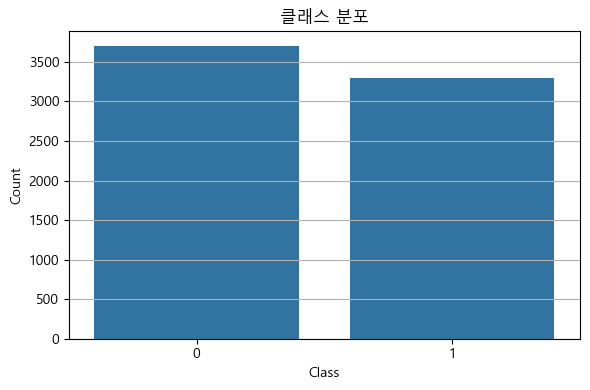

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

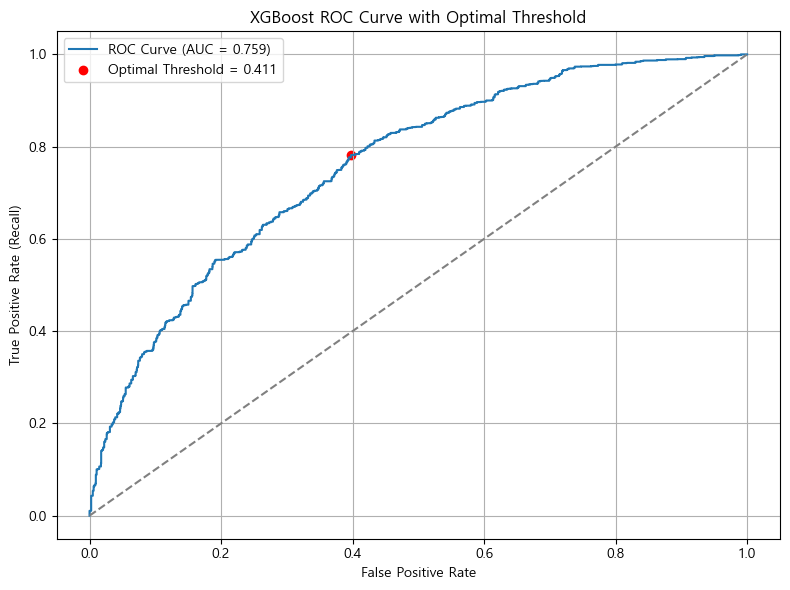

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

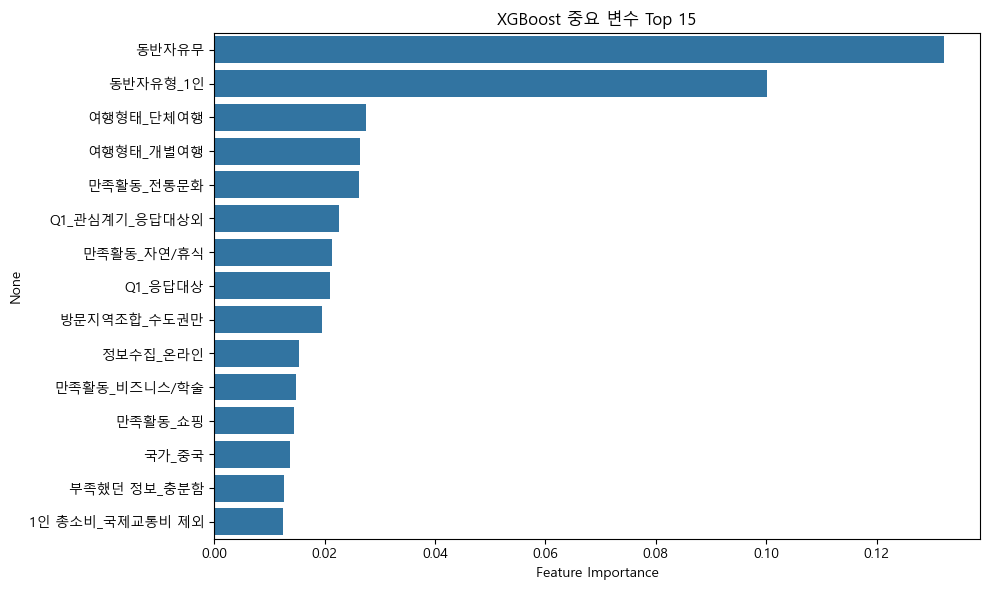

In [36]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

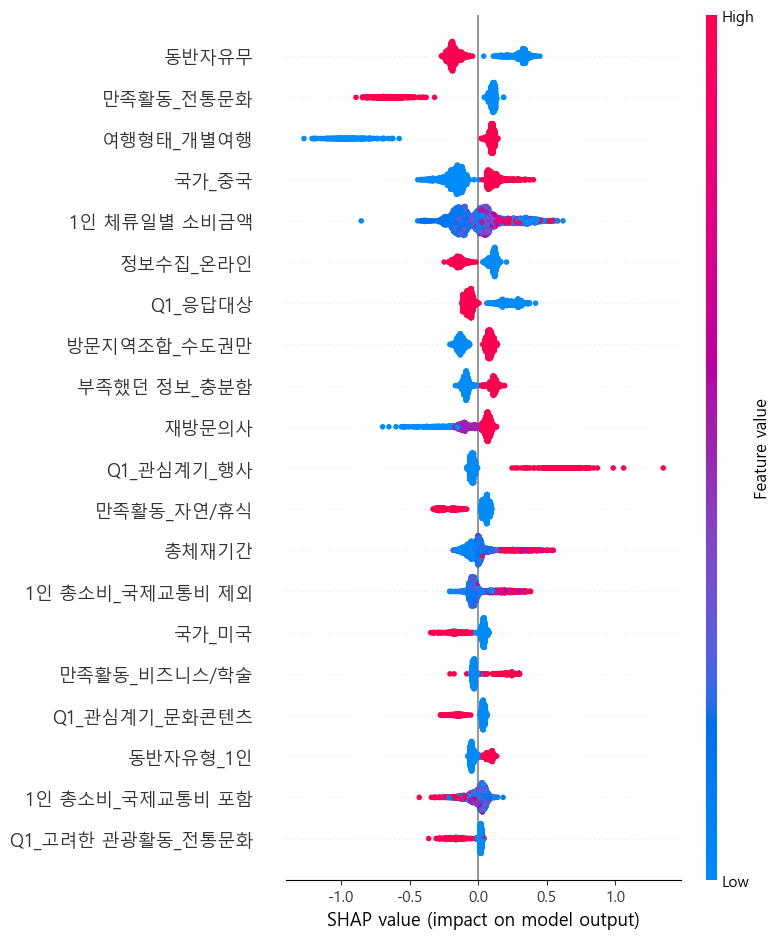

In [37]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [38]:
import pandas as pd
import numpy as np
import shap


# 2. SHAP 값을 numpy 배열로 추출
shap_array = shap_values.values  # (n_samples, n_features)
shap_df = pd.DataFrame(shap_array, columns=X_test.columns)

# 3. 통계 요약
summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_array).mean(axis=0),
    'mean_shap': shap_array.mean(axis=0),
    'std_shap': shap_array.std(axis=0),
    'positive_ratio': (shap_array > 0).mean(axis=0)
})

# 4. 방향성 분류
summary['directionality'] = np.where(summary['positive_ratio'] > 0.9, 'strong_positive',
                            np.where(summary['positive_ratio'] < 0.1, 'strong_negative', 'neutral'))

# 5. 영향력 상위 변수 필터링
threshold = summary['mean_abs_shap'].quantile(0.8)
top_influential = summary[summary['mean_abs_shap'] > threshold]

# 6. 이진 변수만 필터링 (0/1만 존재하는 변수)
binary_cols = [col for col in X_test.columns if set(X_test[col].dropna().unique()).issubset({0, 1})]
summary_binary = top_influential[top_influential['feature'].isin(binary_cols)]

# 7. 출력
print("🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):")
summary_binary[['feature', 'mean_abs_shap', 'mean_shap', 'directionality']].sort_values('mean_abs_shap', ascending=False)


🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):


,feature,mean_abs_shap,mean_shap,directionality
44,동반자유무,0.222630,-0.012352,neutral
60,만족활동_전통문화,0.215518,-0.048048,neutral
0,여행형태_개별여행,0.180009,-0.004239,strong_positive
91,국가_중국,0.155381,-0.082856,neutral
34,정보수집_온라인,0.121649,0.006314,neutral
3,Q1_응답대상,0.113139,0.020705,neutral
63,방문지역조합_수도권만,0.099793,0.006255,neutral
43,부족했던 정보_충분함,0.099246,-0.009017,neutral
10,Q1_관심계기_행사,0.082767,0.000655,strong_negative
59,만족활동_자연/휴식,0.080172,0.012872,neutral


In [31]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [32]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.75530201 0.76918374 0.75458151 0.77489062 0.769291  ]
▶ Mean AUC: 0.7646497766937292
▶ Std AUC: 0.008194187109150505


### Cluster2 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

#### 가중치 반영 X ver

In [52]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['만족활동_쇼핑'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['정보수집_온라인'] == False)
)
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]
good_cols = [col for col in X_test.columns if col.startswith('만족활동_')]
bujok_cols = [col for col in X_test.columns if col.startswith('부족했던 정보_')]
information_cols = [col for col in X_test.columns if col.startswith('정보수집_')]
visit_cols = [col for col in X_test.columns if col.startswith('방문지역_')]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()

X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[good_cols] = False
X_sim_gs['만족활동_쇼핑'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs[information_cols] = False
X_sim_gs['정보수집_온라인'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 103
▶ 평균 확률 변화        : 0.4179
▶ 재방문 확률 상승자 수 : 94명
▶ 상승 비율             : 91.26%
▶ 최대 변화             : 0.6298
▶ 최소 변화             : 0.1009


#### 가중치 반영 O ver

In [53]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['만족활동_쇼핑'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['정보수집_온라인'] == False)
)
X_target_gs = X_test[target_mask].copy()
weights_target_gs = w_test[target_mask].copy()  # 🎯 가중치 추출

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]
good_cols = [col for col in X_test.columns if col.startswith('만족활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs = X_target_gs.copy()

X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[good_cols] = False
X_sim_gs['만족활동_쇼핑'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs[information_cols] = False
X_sim_gs['정보수집_온라인'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# ─────────── threshold 계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs = pd.DataFrame({
    'Before': proba_before_gs,
    'After': proba_after_gs,
    'Change': delta_gs
})
summary_gs['Lifted'] = (summary_gs['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs = weights_target_gs.to_numpy()
assert len(weights_array_gs) == len(delta_gs), "가중치와 delta 길이 불일치"

# 평균 변화량
weighted_mean_delta_gs = np.average(delta_gs, weights=weights_array_gs)

# 상승자 가중치 합
lifted_weights_gs = weights_array_gs[summary_gs['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs = lifted_weights_gs.sum()

# 전체 가중 타깃 수
total_weight_gs = weights_array_gs.sum()

# 상승 비율
weighted_lifted_ratio_gs = (weighted_lifted_sum_gs / total_weight_gs) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_lift_idx = np.argmax(delta_gs)
bottom_lift_idx = np.argmin(delta_gs)

# ─────────── 전체 비재방문자 중 조건부 타깃 비중 계산 ───────────
non_repeat_mask_all = (y_test == 0)
total_nonrepeat_weight = w_test[non_repeat_mask_all].sum()
target_weight_ratio_gs = (total_weight_gs / total_nonrepeat_weight) * 100

# ─────────── 최종 출력 ───────────
print("\n📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight_gs:.0f}명")
print(f"▶ 조건부 타깃 비중 (전체 비재방문자 중) : {target_weight_ratio_gs:.2f}%")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs:.2f}%")
print(f"▶ 최대 변화                : {delta_gs.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs[top_lift_idx]:.4f} → {proba_after_gs[top_lift_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs[bottom_lift_idx]:.4f} → {proba_after_gs[bottom_lift_idx]:.4f}")



📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 103746명
▶ 조건부 타깃 비중 (전체 비재방문자 중) : 11.66%
▶ 평균 확률 변화 (가중)    : 0.4058
▶ 재방문 상승자 수 (가중)  : 88759명
▶ 상승 비율 (가중)         : 85.55%
▶ 최대 변화                : 0.6298
▶ 최소 변화                : 0.1009
▶ 변화량 최댓값 응답자 Before/After: 0.0834 → 0.7132
▶ 변화량 최솟값 응답자 Before/After: 0.2396 → 0.3405


In [54]:
# ─────────── 전체 재방문 확률 증가량 계산 (그리드서치 모델 기준) ───────────
overall_delta_gs = (target_weight_ratio_gs / 100) * weighted_mean_delta_gs

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 그리드서치 모델 기준]")
print(f"▶ 전체 비재방문자 중 타깃이 차지하는 비중       : {target_weight_ratio_gs:.2f}%")
print(f"▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : {weighted_mean_delta_gs:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : {overall_delta_gs:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 그리드서치 모델 기준]
▶ 전체 비재방문자 중 타깃이 차지하는 비중       : 11.66%
▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : 0.4058
▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : 0.0473


### (4) 시뮬레이션 - 전체 비재방문객에 대해

#### 가중치 반영 X ver

In [55]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()

X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all[good_cols] = False
X_sim_gs_all['만족활동_쇼핑'] = True

X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True

X_sim_gs_all[information_cols] = False
X_sim_gs_all['정보수집_온라인'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 1111
▶ 평균 확률 변화         : 0.2222
▶ 재방문 가능성 상승자 수 : 1038명
▶ 상승 비율               : 93.43%
▶ 최대 변화               : 0.6747
▶ 최소 변화               : -0.1565


#### 가중치 반영 O ver

In [56]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 필터
non_repeat_mask_gs = (y_test == 0)
X_non_repeat_gs = X_test[non_repeat_mask_gs].copy()
weights_non_repeat_gs = w_test[non_repeat_mask_gs].copy()

# 예측 전 확률
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs_all = X_non_repeat_gs.copy()

X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all[good_cols] = False
X_sim_gs_all['만족활동_쇼핑'] = True

X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True

X_sim_gs_all[information_cols] = False
X_sim_gs_all['정보수집_온라인'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# ─────────── threshold 재계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs_all = weights_non_repeat_gs.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_gs_all = np.average(delta_gs_all, weights=weights_array_gs_all)

# 재방문 상승자 가중치 합
lifted_weights_gs_all = weights_array_gs_all[summary_gs_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs_all = lifted_weights_gs_all.sum()

# 전체 가중 대상 수
total_weight_gs_all = weights_array_gs_all.sum()

# 상승 비율 (가중)
weighted_lifted_ratio_gs_all = (weighted_lifted_sum_gs_all / total_weight_gs_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_gs_all = np.argmax(delta_gs_all)
bottom_idx_gs_all = np.argmin(delta_gs_all)

# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_gs_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs_all:.2f}%")
print(f"▶ 최대 변화                : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs_all[top_idx_gs_all]:.4f} → {proba_after_gs_all[top_idx_gs_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs_all[bottom_idx_gs_all]:.4f} → {proba_after_gs_all[bottom_idx_gs_all]:.4f}")


📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]
▶ 가중 대상 수             : 890054명
▶ 평균 확률 변화 (가중)    : 0.2240
▶ 재방문 상승자 수 (가중)  : 818970명
▶ 상승 비율 (가중)         : 92.01%
▶ 최대 변화                : 0.6747
▶ 최소 변화                : -0.1565
▶ 변화량 최댓값 응답자 Before/After: 0.1024 → 0.7771
▶ 변화량 최솟값 응답자 Before/After: 0.7849 → 0.6284


In [57]:
# ─────────── 전체 재방문 확률 증가 기여 계산 (그리드서치 모델 기준) ───────────
overall_delta_gs_all = weighted_mean_delta_gs_all  # 전체 비재방문자 대상이므로 비중 = 1

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상, 그리드서치 모델]")
print(f"▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여                    : {overall_delta_gs_all:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상, 그리드서치 모델]
▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): 0.2240
▶ 전체 재방문 확률 증가 기여                    : 0.2240


# Cluster 3

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [126]:
# 클러스터 국가 리스트
cluster3_countries = [
    '국가_홍콩', '국가_대만', '국가_싱가포르', 
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster3_mask = df[cluster3_countries].any(axis=1)
df_c3 = df[cluster3_mask].copy()

In [128]:
# 종속변수
y = df_c3["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c3.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c3["가중치"]

In [129]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [130]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [131]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.586]
Accuracy     : 0.696
Precision    : 0.748
Recall       : 0.753
F1 Score     : 0.751
ROC AUC      : 0.730

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.614     0.608     0.611 257736.8299999999
           1      0.748     0.753     0.751 398690.6599999995

    accuracy                          0.696 656427.4899999994
   macro avg      0.681     0.680     0.681 656427.4899999994
weighted avg      0.695     0.696     0.696 656427.4899999994


▶ [혼동 행렬]
[[181 136]
 [122 408]]


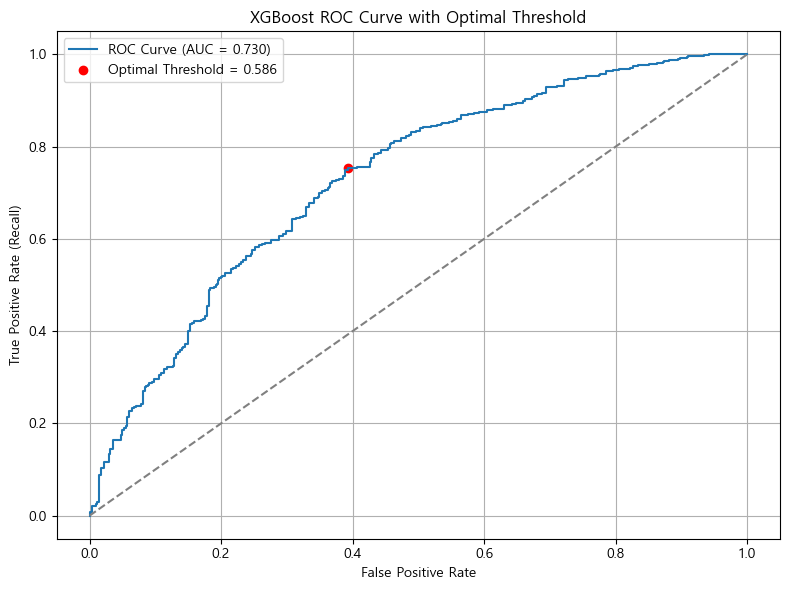

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

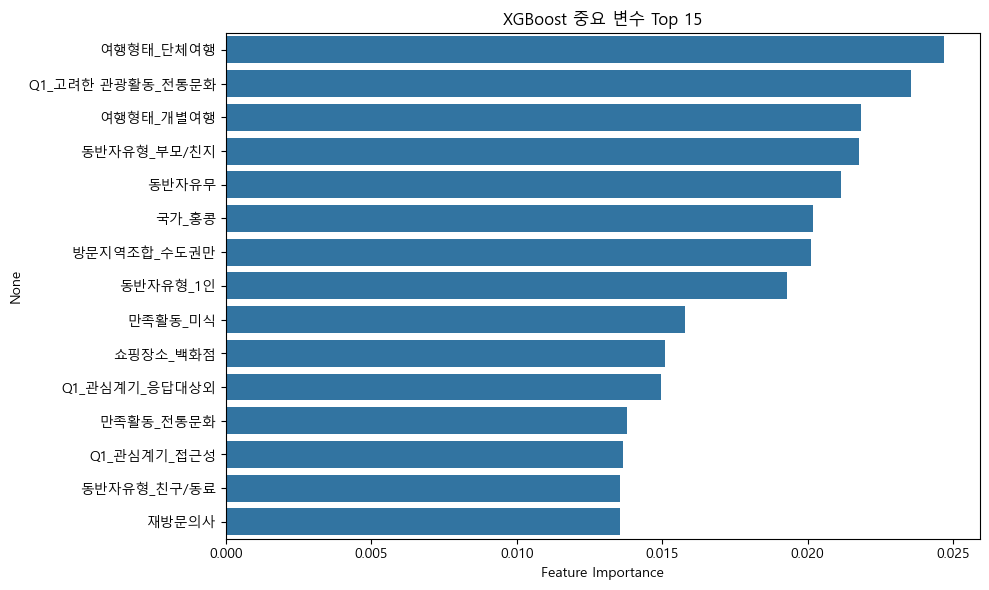

In [133]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

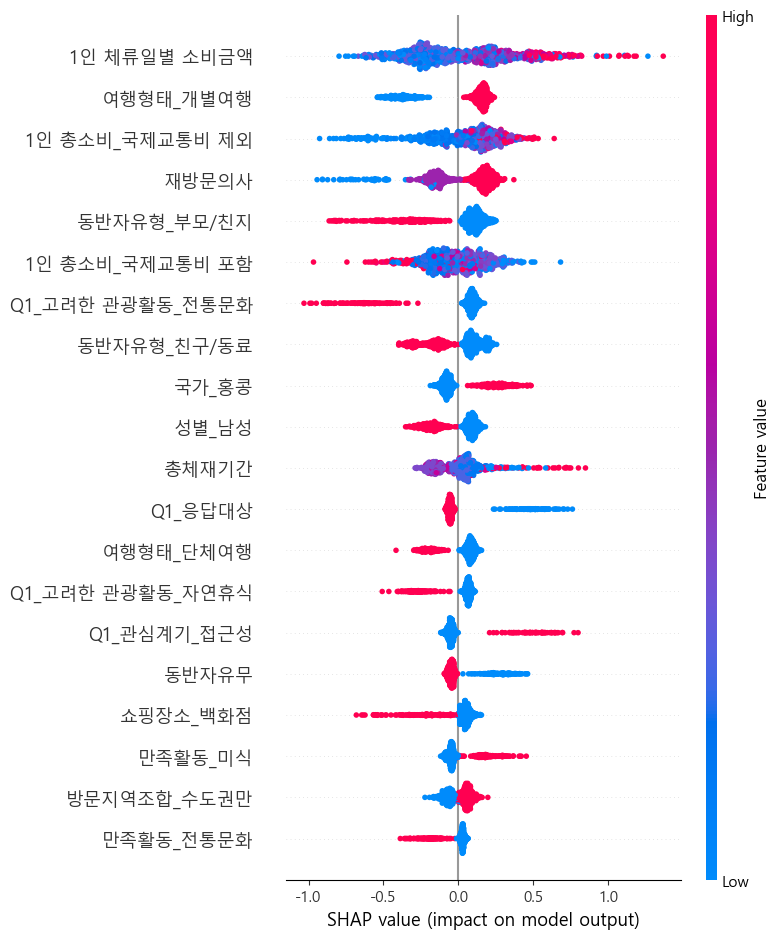

In [134]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [135]:
import pandas as pd
import numpy as np
import shap

# 1. SHAP 계산 (너가 이미 실행한 부분)
# explainer = shap.Explainer(model)
# shap_values = explainer(X_test)

# 2. SHAP 값을 numpy 배열로 추출
shap_array = shap_values.values  # (n_samples, n_features)
shap_df = pd.DataFrame(shap_array, columns=X_test.columns)

# 3. 통계 요약
summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_array).mean(axis=0),
    'mean_shap': shap_array.mean(axis=0),
    'std_shap': shap_array.std(axis=0),
    'positive_ratio': (shap_array > 0).mean(axis=0)
})

# 4. 방향성 분류
summary['directionality'] = np.where(summary['positive_ratio'] > 0.9, 'strong_positive',
                            np.where(summary['positive_ratio'] < 0.1, 'strong_negative', 'neutral'))

# 5. 영향력 상위 변수 필터링
threshold = summary['mean_abs_shap'].quantile(0.8)
top_influential = summary[summary['mean_abs_shap'] > threshold]

# 6. 이진 변수만 필터링 (0/1만 존재하는 변수)
binary_cols = [col for col in X_test.columns if set(X_test[col].dropna().unique()).issubset({0, 1})]
summary_binary = top_influential[top_influential['feature'].isin(binary_cols)]

# 7. 출력
print("🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):")
summary_binary[['feature', 'mean_abs_shap', 'mean_shap', 'directionality']].sort_values('mean_abs_shap', ascending=False)


🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):


,feature,mean_abs_shap,mean_shap,directionality
0,여행형태_개별여행,0.209564,0.032950,neutral
48,동반자유형_부모/친지,0.174292,-0.000562,neutral
20,Q1_고려한 관광활동_전통문화,0.155628,0.005659,neutral
50,동반자유형_친구/동료,0.142947,0.000150,neutral
98,국가_홍콩,0.134407,0.017782,neutral
100,성별_남성,0.122446,-0.005570,neutral
3,Q1_응답대상,0.112679,0.016522,neutral
2,여행형태_단체여행,0.104116,0.022553,neutral
19,Q1_고려한 관광활동_자연휴식,0.099740,0.009560,neutral
8,Q1_관심계기_접근성,0.088616,-0.008825,strong_negative


In [136]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7156774158875563, 0.7120634497504696, 0.7343921132864599, 0.722244484186293, 0.696114183215319]
▶ Mean AUC: 0.7160983292652195
▶ Std AUC : 0.012555964863310369


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [137]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.6988111834875653


In [138]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.6, 'subsample': 0.8}
Best AUC Score: 0.7042977621241834


In [139]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.05, 'n_estimators': 100}
Best AUC Score: 0.7128322519001972


In [140]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best AUC Score: 0.7128460545948018


In [141]:
best_model = grid_search_4.best_estimator_

In [142]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [143]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.8
colsample_bytree = 0.6
learning_rate    = 0.05
n_estimators     = 100
gamma            = 0
reg_alpha        = 0.1
reg_lambda       = 0.5


In [144]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.599]
Accuracy     : 0.702
Precision    : 0.771
Recall       : 0.726
F1 Score     : 0.748
ROC AUC      : 0.742

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.611     0.666     0.637 257736.8299999999
           1      0.771     0.726     0.748 398690.6599999995

    accuracy                          0.702 656427.4899999994
   macro avg      0.691     0.696     0.693 656427.4899999994
weighted avg      0.708     0.702     0.704 656427.4899999994


▶ [혼동 행렬]
[[195 122]
 [138 392]]


클래스별 개수:
재방문여부
1    1766
0    1055
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
1    62.6
0    37.4
Name: proportion, dtype: float64


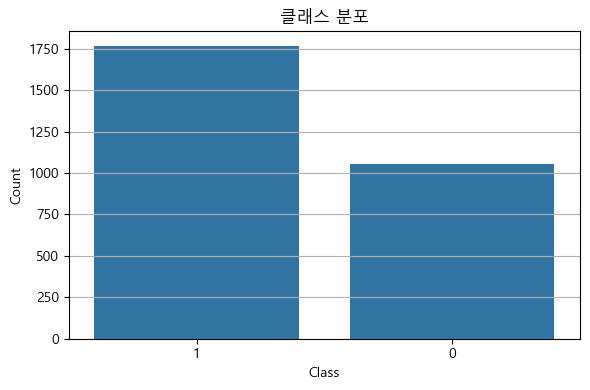

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

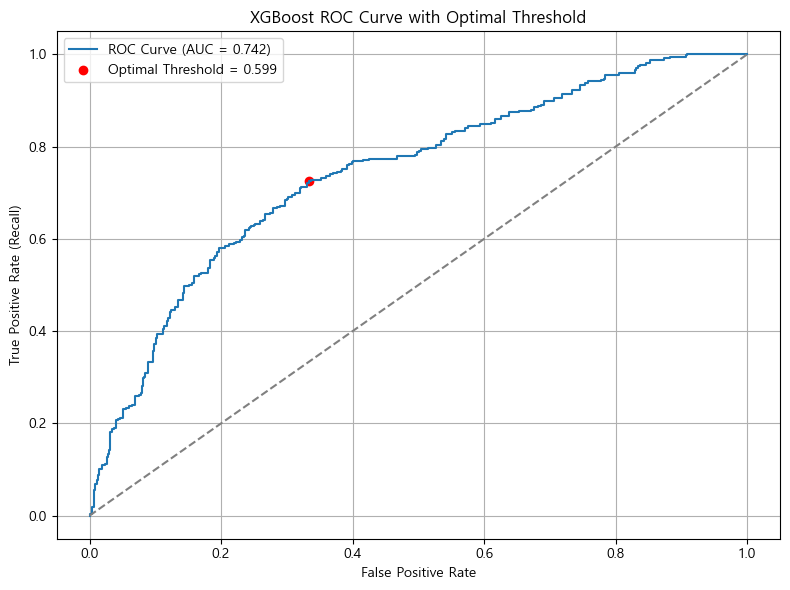

In [146]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

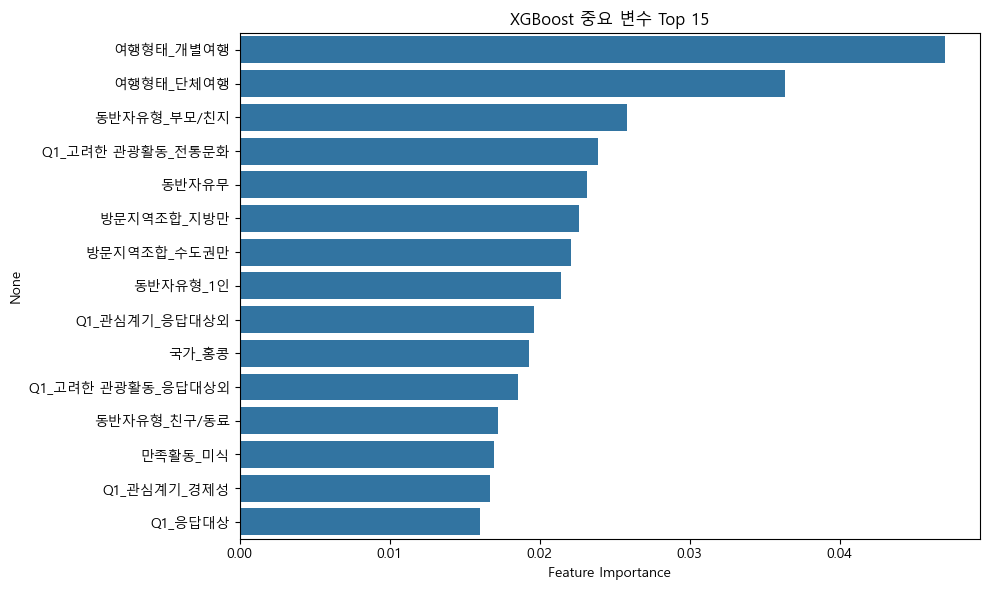

In [147]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

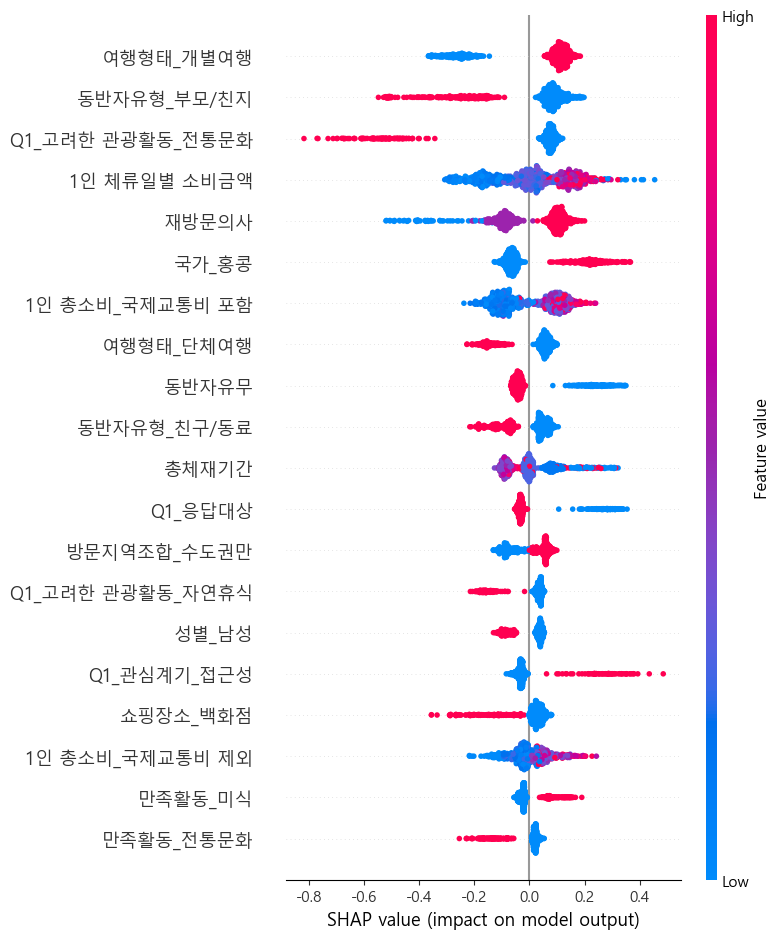

In [148]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [149]:
import pandas as pd
import numpy as np
import shap

# 1. SHAP 계산 (너가 이미 실행한 부분)
# explainer = shap.Explainer(model)
# shap_values = explainer(X_test)

# 2. SHAP 값을 numpy 배열로 추출
shap_array = shap_values.values  # (n_samples, n_features)
shap_df = pd.DataFrame(shap_array, columns=X_test.columns)

# 3. 통계 요약
summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_array).mean(axis=0),
    'mean_shap': shap_array.mean(axis=0),
    'std_shap': shap_array.std(axis=0),
    'positive_ratio': (shap_array > 0).mean(axis=0)
})

# 4. 방향성 분류
summary['directionality'] = np.where(summary['positive_ratio'] > 0.9, 'strong_positive',
                            np.where(summary['positive_ratio'] < 0.1, 'strong_negative', 'neutral'))

# 5. 영향력 상위 변수 필터링
threshold = summary['mean_abs_shap'].quantile(0.8)
top_influential = summary[summary['mean_abs_shap'] > threshold]

# 6. 이진 변수만 필터링 (0/1만 존재하는 변수)
binary_cols = [col for col in X_test.columns if set(X_test[col].dropna().unique()).issubset({0, 1})]
summary_binary = top_influential[top_influential['feature'].isin(binary_cols)]

# 7. 출력
print("🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):")
summary_binary[['feature', 'mean_abs_shap', 'mean_shap', 'directionality']].sort_values('mean_abs_shap', ascending=False)


🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):


,feature,mean_abs_shap,mean_shap,directionality
0,여행형태_개별여행,0.149060,0.027114,neutral
48,동반자유형_부모/친지,0.131954,0.006430,neutral
20,Q1_고려한 관광활동_전통문화,0.131528,0.004609,neutral
98,국가_홍콩,0.110057,0.015305,neutral
2,여행형태_단체여행,0.077518,0.016086,neutral
44,동반자유무,0.075477,0.004440,neutral
50,동반자유형_친구/동료,0.067929,-0.002732,neutral
3,Q1_응답대상,0.064786,0.008146,neutral
63,방문지역조합_수도권만,0.059856,0.000479,neutral
19,Q1_고려한 관광활동_자연휴식,0.055363,0.003945,neutral


In [150]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [151]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.73815835 0.73696011 0.7317643  0.71500879 0.71404213]
▶ Mean AUC: 0.7271867368059037
▶ Std AUC: 0.010563448521599643


### Cluster3 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

In [102]:
df_c3[['총체재기간','1인 체류일별 소비금액']].describe()

,총체재기간,1인 체류일별 소비금액
count,2821.000000,2821.000000
mean,6.267990,246.894069
std,5.248755,226.678068
min,1.000000,7.540984
25%,5.000000,139.050000
50%,5.000000,199.112000
75%,7.000000,283.325000
max,90.000000,4912.000000


- 총체재기간 중앙값 5일 -> 평균을 넘도록 +1 or +2 해보기  
- 1인 체류일별 소비금액 중앙값 199 -> 평균을 넘도록 +50 해보기

#### 가중치 반영 X ver

In [199]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['총체재기간'] <= 5) &
    (X_test['1인 체류일별 소비금액'] <= 200)
)
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]
good_cols = [col for col in X_test.columns if col.startswith('만족활동_')]
bujok_cols = [col for col in X_test.columns if col.startswith('부족했던 정보_')]
information_cols = [col for col in X_test.columns if col.startswith('정보수집_')]
visit_cols = [col for col in X_test.columns if col.startswith('방문지역조합_')]
shopping_cols = [col for col in X_test.columns if col.startswith('쇼핑장소_')]
partner_cols = [col for col in X_test.columns if col.startswith('동반자유형_')]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()

X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs['총체재기간'] += 7

X_sim_gs['1인 체류일별 소비금액'] += 100

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 31
▶ 평균 확률 변화        : 0.1680
▶ 재방문 확률 상승자 수 : 12명
▶ 상승 비율             : 38.71%
▶ 최대 변화             : 0.2934
▶ 최소 변화             : -0.1144


#### 가중치 반영 O ver

In [200]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['총체재기간'] <= 5) &
    (X_test['1인 체류일별 소비금액'] <= 200)
)
X_target_gs = X_test[target_mask].copy()
weights_target_gs = w_test[target_mask].copy()  # 🎯 가중치 추출

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]
good_cols = [col for col in X_test.columns if col.startswith('만족활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs = X_target_gs.copy()

X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs['총체재기간'] += 7

X_sim_gs['1인 체류일별 소비금액'] += 100

# ─────────── 예측 및 변화량 계산 ───────────
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# ─────────── threshold 계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs = pd.DataFrame({
    'Before': proba_before_gs,
    'After': proba_after_gs,
    'Change': delta_gs
})
summary_gs['Lifted'] = (summary_gs['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs = weights_target_gs.to_numpy()
assert len(weights_array_gs) == len(delta_gs), "가중치와 delta 길이 불일치"

# 평균 변화량
weighted_mean_delta_gs = np.average(delta_gs, weights=weights_array_gs)

# 상승자 가중치 합
lifted_weights_gs = weights_array_gs[summary_gs['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs = lifted_weights_gs.sum()

# 전체 가중 타깃 수
total_weight_gs = weights_array_gs.sum()

# 상승 비율
weighted_lifted_ratio_gs = (weighted_lifted_sum_gs / total_weight_gs) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_lift_idx = np.argmax(delta_gs)
bottom_lift_idx = np.argmin(delta_gs)

# ─────────── 전체 비재방문자 중 조건부 타깃 비중 계산 ───────────
non_repeat_mask_all = (y_test == 0)
total_nonrepeat_weight = w_test[non_repeat_mask_all].sum()
target_weight_ratio_gs = (total_weight_gs / total_nonrepeat_weight) * 100

# ─────────── 최종 출력 ───────────
print("\n📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight_gs:.0f}명")
print(f"▶ 조건부 타깃 비중 (전체 비재방문자 중) : {target_weight_ratio_gs:.2f}%")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs:.2f}%")
print(f"▶ 최대 변화                : {delta_gs.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs[top_lift_idx]:.4f} → {proba_after_gs[top_lift_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs[bottom_lift_idx]:.4f} → {proba_after_gs[bottom_lift_idx]:.4f}")



📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 31756명
▶ 조건부 타깃 비중 (전체 비재방문자 중) : 12.32%
▶ 평균 확률 변화 (가중)    : 0.1703
▶ 재방문 상승자 수 (가중)  : 11377명
▶ 상승 비율 (가중)         : 35.82%
▶ 최대 변화                : 0.2934
▶ 최소 변화                : -0.1144
▶ 변화량 최댓값 응답자 Before/After: 0.2398 → 0.5333
▶ 변화량 최솟값 응답자 Before/After: 0.6210 → 0.5066


In [201]:
# ─────────── 전체 재방문 확률 증가량 계산 ───────────
# 단위: 평균 변화량 * 전체에서 차지하는 비중
overall_delta_gs = (target_weight_ratio_gs / 100) * weighted_mean_delta_gs

print(f"\n📘 [전체 관점에서의 재방문 확률 상승 효과]")
print(f"▶ 전체 비재방문자 중 타깃이 차지하는 비중       : {target_weight_ratio_gs:.2f}%")
print(f"▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : {weighted_mean_delta_gs:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : {overall_delta_gs:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과]
▶ 전체 비재방문자 중 타깃이 차지하는 비중       : 12.32%
▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : 0.1703
▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : 0.0210


### (4) 시뮬레이션 - 전체 비재방문객에 대해

#### 가중치 반영 X ver

In [192]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()

X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all['총체재기간'] += 7

X_sim_gs_all['1인 체류일별 소비금액'] += 100

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 317
▶ 평균 확률 변화         : 0.0877
▶ 재방문 가능성 상승자 수 : 203명
▶ 상승 비율               : 64.04%
▶ 최대 변화               : 0.2934
▶ 최소 변화               : -0.1144


#### 가중치 반영 O ver

In [193]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 필터
non_repeat_mask_gs = (y_test == 0)
X_non_repeat_gs = X_test[non_repeat_mask_gs].copy()
weights_non_repeat_gs = w_test[non_repeat_mask_gs].copy()

# 예측 전 확률
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs_all = X_non_repeat_gs.copy()

X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all['총체재기간'] += 7

X_sim_gs_all['1인 체류일별 소비금액'] += 100

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# ─────────── threshold 재계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs_all = weights_non_repeat_gs.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_gs_all = np.average(delta_gs_all, weights=weights_array_gs_all)

# 재방문 상승자 가중치 합
lifted_weights_gs_all = weights_array_gs_all[summary_gs_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs_all = lifted_weights_gs_all.sum()

# 전체 가중 대상 수
total_weight_gs_all = weights_array_gs_all.sum()

# 상승 비율 (가중)
weighted_lifted_ratio_gs_all = (weighted_lifted_sum_gs_all / total_weight_gs_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_gs_all = np.argmax(delta_gs_all)
bottom_idx_gs_all = np.argmin(delta_gs_all)

# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_gs_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs_all:.2f}%")
print(f"▶ 최대 변화                : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs_all[top_idx_gs_all]:.4f} → {proba_after_gs_all[top_idx_gs_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs_all[bottom_idx_gs_all]:.4f} → {proba_after_gs_all[bottom_idx_gs_all]:.4f}")


📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]
▶ 가중 대상 수             : 257737명
▶ 평균 확률 변화 (가중)    : 0.0940
▶ 재방문 상승자 수 (가중)  : 154009명
▶ 상승 비율 (가중)         : 59.75%
▶ 최대 변화                : 0.2934
▶ 최소 변화                : -0.1144
▶ 변화량 최댓값 응답자 Before/After: 0.2398 → 0.5333
▶ 변화량 최솟값 응답자 Before/After: 0.6210 → 0.5066


In [194]:
# ─────────── 전체 재방문 확률 증가 기여 계산 ───────────
overall_delta_gs_all = weighted_mean_delta_gs_all  # 전체 대상이므로 비중 = 1

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상]")
print(f"▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여                    : {overall_delta_gs_all:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상]
▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): 0.0940
▶ 전체 재방문 확률 증가 기여                    : 0.0940
